# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

# OBJECTIVE

The goal of the project is to distinguish the starbucks app users into clusters of who will likely respond to the different offers.

In [87]:
import pandas as pd
import numpy as np
import math
import json
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import cluster
from sklearn.cluster import KMeans

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Looking at the Data

In [2]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [3]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [4]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


# Cleaning Data

In [5]:
# Check how many channels are there
all_channels = []

for channel in portfolio['channels']:
    for t in channel:
        if t not in all_channels:
            all_channels.append(t)
            
all_channels

['email', 'mobile', 'social', 'web']

In [6]:
#Check how many different offer_types are there
portfolio['offer_type'].unique()

array(['bogo', 'informational', 'discount'], dtype=object)

In [7]:
#One hot encoding the channels data
for channel in all_channels:
    portfolio[channel] = portfolio['channels'].apply(lambda x: 1 if channel in x else 0)
    
prtfolio = portfolio.drop('channels', axis=1, inplace=True)
portfolio.head()

,reward,difficulty,duration,offer_type,id,email,mobile,social,web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1


In [8]:
#Seperate value column into value type and value column
transcript['value_type'] = transcript['value'].apply(lambda x: list(x.keys())[0])
transcript['value'] = transcript['value'].apply(lambda x : list(x.values())[0])

transcript.head()



,person,event,value,time,value_type
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,offer id
1,a03223e636434f42ac4c3df47e8bac43,offer received,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,offer id
2,e2127556f4f64592b11af22de27a7932,offer received,2906b810c7d4411798c6938adc9daaa5,0,offer id
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,fafdcd668e3743c1bb461111dcafc2a4,0,offer id
4,68617ca6246f4fbc85e91a2a49552598,offer received,4d5c57ea9a6940dd891ad53e9dbe8da0,0,offer id


In [9]:
#Replace empty gender values and income values
profile['gender'].fillna('Unknown', inplace =True)

mean_value = profile.income.mean()
profile['income'].fillna(mean_value, inplace=True)

In [10]:
#Dropping beace_member_on column and creating new columns representing year, month, date and member_date

profile['member_year'] = profile.became_member_on.apply(lambda x: int(str(x)[:4]))
profile['member_month'] = profile.became_member_on.apply(lambda x: int(str(x)[4:6]))
profile['member_day'] = profile.became_member_on.apply(lambda x: int(str(x)[6:]))

profile['member_date'] = profile.became_member_on.apply(lambda x:datetime.datetime.strptime(str(x),'%Y%m%d'))

profile.drop('became_member_on', axis=1, inplace = True)
profile.head()



,gender,age,id,income,member_year,member_month,member_day,member_date
0,Unknown,118,68be06ca386d4c31939f3a4f0e3dd783,65404.991568,2017,2,12,2017-02-12
1,F,55,0610b486422d4921ae7d2bf64640c50b,112000.000000,2017,7,15,2017-07-15
2,Unknown,118,38fe809add3b4fcf9315a9694bb96ff5,65404.991568,2018,7,12,2018-07-12
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,100000.000000,2017,5,9,2017-05-09
4,Unknown,118,a03223e636434f42ac4c3df47e8bac43,65404.991568,2017,8,4,2017-08-04


# DATA ANALYSIS

Take a look at the distribution of gender in the dataset, as well as how gender compares to income. Looking at the subscriptions data. Distribution of bogo and discount rewards and how they compare in the dataset.

Text(0.5, 0, 'Gender')

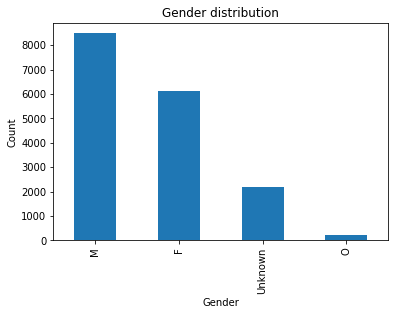

In [19]:
# Take a look at the gender distribution
profile.gender.value_counts().plot(kind = 'bar')
#profile.plot(kind='bar')

plt.title('Gender distribution')
plt.ylabel('Count')
plt.xlabel('Gender')

Text(1, 66404.9915682968, 'Average Income')

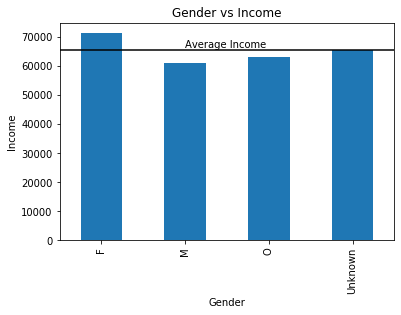

In [41]:
#Total income vs Gender plot
gender_income = profile.groupby('gender', as_index=False).agg({'income':'mean'}).plot(kind = 'bar', x='gender', y='income', legend=False)
plt.ylabel('Income')
plt.xlabel('Gender')
plt.title('Gender vs Income')
plt.hlines(mean_value, -50, 1000)
plt.text(1, mean_value+1000, 'Average Income')

<Figure size 1440x720 with 0 Axes>

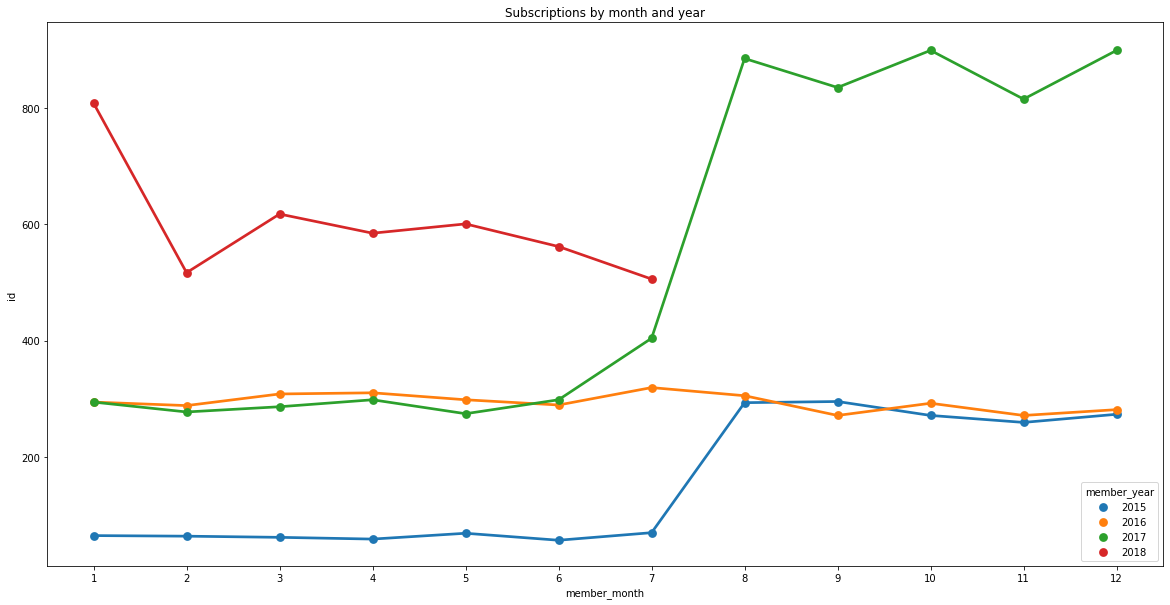

<Figure size 1440x720 with 0 Axes>

In [48]:
# Plot memberships vs year
membership_subs = profile[profile['member_year']>2014].groupby(['member_year','member_month'], as_index=False).agg({'id':'count'})
plt.figure(figsize=(20,10))
sns.pointplot(x='member_month', y = 'id', hue='member_year', data = membership_subs)
plt.ylabel = ('Customer Subscriptions')
plt.xlabel = ('Month')
plt.title('Subscriptions by month and year')


In [50]:
trans_and_offers = pd.merge(transcript[(transcript['value_type'] == 'offer_id') & (transcript['event'] == 'offer completed')]
                            , portfolio, how = 'inner', left_on = 'value', right_on = 'id')
trans_and_offers['offer_type'].value_counts(normalize = True)
trans_and_offers

,person,event,value,time,value_type,reward,difficulty,duration,offer_type,id,email,mobile,social,web
0,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,2906b810c7d4411798c6938adc9daaa5,0,offer_id,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1
1,73ffefd41e9a4ca3ab26b2b3697c6eb7,offer completed,2906b810c7d4411798c6938adc9daaa5,0,offer_id,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1
2,24115a61df25473e84a8a03f3c98de1a,offer completed,2906b810c7d4411798c6938adc9daaa5,0,offer_id,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1
3,2481f1fcfbcb4b288e5a03af02d95373,offer completed,2906b810c7d4411798c6938adc9daaa5,0,offer_id,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1
4,a45b69f1c8554ae7af83e74426ca437a,offer completed,2906b810c7d4411798c6938adc9daaa5,0,offer_id,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33574,5cb65af515664bb0b39cdaa089244dc7,offer completed,0b1e1539f2cc45b7b9fa7c272da2e1d7,714,offer_id,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1
33575,0dc85918181e4c3eb0e412d37fa8a552,offer completed,0b1e1539f2cc45b7b9fa7c272da2e1d7,714,offer_id,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1
33576,f74033a8c6834303bd1b3ef0c98d11d8,offer completed,0b1e1539f2cc45b7b9fa7c272da2e1d7,714,offer_id,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1
33577,f3e801caeafe4899b3b989b586e74ac7,offer completed,0b1e1539f2cc45b7b9fa7c272da2e1d7,714,offer_id,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1


In [60]:
one_person_transaction = transcript[(transcript['person']== '8dbfa485249f409aa223a2130f40634a') 
                                   & (transcript['value_type']=='amount')].reset_index()
one_person_transaction.drop('index', axis=1, inplace=True)

#Create days since last purchase column
one_person_transaction['DaysFromLastPurchase'] = one_person_transaction.time.diff()
one_person_transaction.iloc[0,-1] = one_person_transaction.loc[0, 'time']

#Convert it into float
one_person_transaction['value'] = one_person_transaction['value'].apply(lambda x:float(x))


one_person_transaction

,person,event,value,time,value_type,DaysFromLastPurchase
0,8dbfa485249f409aa223a2130f40634a,transaction,3.86,6,amount,6.0
1,8dbfa485249f409aa223a2130f40634a,transaction,0.88,30,amount,24.0
2,8dbfa485249f409aa223a2130f40634a,transaction,2.86,36,amount,6.0
3,8dbfa485249f409aa223a2130f40634a,transaction,0.17,54,amount,18.0
4,8dbfa485249f409aa223a2130f40634a,transaction,1.02,78,amount,24.0
5,8dbfa485249f409aa223a2130f40634a,transaction,0.49,84,amount,6.0
6,8dbfa485249f409aa223a2130f40634a,transaction,1.72,108,amount,24.0
7,8dbfa485249f409aa223a2130f40634a,transaction,1.66,186,amount,78.0
8,8dbfa485249f409aa223a2130f40634a,transaction,0.61,192,amount,6.0
9,8dbfa485249f409aa223a2130f40634a,transaction,1.31,228,amount,36.0


In [61]:
#average transaction amount, average days between purchases

one_person_transaction.groupby('person').agg({
    'value':'mean',
    'DaysFromLastPurchase':'mean',
    'time':'mean'
})

,value,DaysFromLastPurchase,time
person,,,
8dbfa485249f409aa223a2130f40634a,2.123889,18.833333,379


In [63]:
one_person_completion = pd.merge(
                    transcript[transcript['event'] == 'offer received']
                    , transcript[transcript['event'] == 'offer completed']
                    , how = 'left'
                    , left_on = ['person','value']
                    , right_on = ['person','value']
        )
one_person_completion['time_y'] = one_person_completion['time_y'].apply(lambda x: float(x))
one_person_completion['time_x'] = one_person_completion['time_x'].apply(lambda x: float(x))


In [64]:
one_person_completion.head()

,person,event_x,value,time_x,value_type_x,event_y,time_y,value_type_y
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,offer id,offer completed,132.0,offer_id
1,a03223e636434f42ac4c3df47e8bac43,offer received,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,offer id,NaN,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,2906b810c7d4411798c6938adc9daaa5,0.0,offer id,NaN,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,fafdcd668e3743c1bb461111dcafc2a4,0.0,offer id,NaN,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,offer id,NaN,NaN,NaN


In [71]:
completion = one_person_completion[(
    (one_person_completion['time_y'] < (one_person_completion['time_x']+20)) 
    &(one_person_completion['time_y'] >= one_person_completion['time_x']))
    
    |
    
    (pd.isnull(one_person_completion['event_y'])==True)][['person','time_x','value','event_y','time_y']]

completion['DaysToCompleteOffer'] = completion['time_y'] - completion['time_x']
completion['CompletedOffer'] = completion['event_y'].apply(lambda x: 0 if pd.isnull(x) == True else 1)


In [72]:
completion

,person,time_x,value,event_y,time_y,DaysToCompleteOffer,CompletedOffer
1,a03223e636434f42ac4c3df47e8bac43,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN,0
2,e2127556f4f64592b11af22de27a7932,0.0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0.0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN,0
4,68617ca6246f4fbc85e91a2a49552598,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN,0
7,c4863c7985cf408faee930f111475da3,0.0,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...
86425,f924927e7f844ecebf87eef93f4d2688,576.0,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,NaN,0
86426,a57890c3bbb7463e9018abb7fecadb15,576.0,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,NaN,0
86429,6d5f3a774f3d4714ab0c092238f3a1d7,576.0,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,NaN,NaN,0
86430,9dc1421481194dcd9400aec7c9ae6366,576.0,ae264e3637204a6fb9bb56bc8210ddfd,offer completed,594.0,18.0,1


In [73]:
completion[completion['person'] == '8dbfa485249f409aa223a2130f40634a']


,person,time_x,value,event_y,time_y,DaysToCompleteOffer,CompletedOffer
5765,8dbfa485249f409aa223a2130f40634a,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN,0
63399,8dbfa485249f409aa223a2130f40634a,504.0,ae264e3637204a6fb9bb56bc8210ddfd,NaN,NaN,NaN,0


In [74]:
completion[completion['person'] == '9dc1421481194dcd9400aec7c9ae6366']


,person,time_x,value,event_y,time_y,DaysToCompleteOffer,CompletedOffer
57550,9dc1421481194dcd9400aec7c9ae6366,408.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,offer completed,414.0,6.0,1
86430,9dc1421481194dcd9400aec7c9ae6366,576.0,ae264e3637204a6fb9bb56bc8210ddfd,offer completed,594.0,18.0,1


In [76]:
completion[completion['person'] == '9dc1421481194dcd9400aec7c9ae6366'].groupby('person').agg({
    
    'time_x':'min' 
    , 'CompletedOffer': 'mean' 
    , 'DaysToCompleteOffer': 'mean' 
})

,time_x,CompletedOffer,DaysToCompleteOffer
person,,,
9dc1421481194dcd9400aec7c9ae6366,408.0,1,12.0


In [79]:
offers_df = pd.merge(completion
         ,portfolio
         , how = 'inner'
         , left_on = 'value'
         , right_on = 'id'
        )[['person','time_x','value','CompletedOffer','DaysToCompleteOffer'
          , 'difficulty','duration','offer_type','reward','email','mobile','social','web'
          ]]
offers_df.columns = ['person','offer_time','value','CompletedOffer','DaysToCompleteOffer'
                          ,'difficulty','duration','offer_type','reward'
                          , 'email','mobile','social','web'
                        ]
offers_df['NetReward'] = offers_df['reward'] - offers_df['difficulty']
offers_df.tail()

,person,offer_time,value,CompletedOffer,DaysToCompleteOffer,difficulty,duration,offer_type,reward,email,mobile,social,web,NetReward
48845,db1805ed333844978e8b46ed3e4643ae,576.0,f19421c1d4aa40978ebb69ca19b0e20d,0,NaN,5,5,bogo,5,1,1,1,1,0
48846,eec70ab28af74a22a4aeb889c0317944,576.0,f19421c1d4aa40978ebb69ca19b0e20d,1,18.0,5,5,bogo,5,1,1,1,1,0
48847,31e915c24163436790b97c1d45b545f6,576.0,f19421c1d4aa40978ebb69ca19b0e20d,1,18.0,5,5,bogo,5,1,1,1,1,0
48848,361539b15a6243dc834c6b25e481570b,576.0,f19421c1d4aa40978ebb69ca19b0e20d,0,NaN,5,5,bogo,5,1,1,1,1,0
48849,eb7dd979f4644052a5c401a01f129132,576.0,f19421c1d4aa40978ebb69ca19b0e20d,0,NaN,5,5,bogo,5,1,1,1,1,0


In [80]:
final_offers_df = offers_df.groupby(['offer_type','difficulty','reward'], as_index = False).agg({
    'CompletedOffer':['mean', 'sum'] 
    , 'DaysToCompleteOffer':'mean' 
    , 'NetReward': 'max' 
})

final_offers_df.columns.droplevel(1)
final_offers_df.columns = ['offer_type','difficulty','reward','CompletedOffers','TotalCompletions'
                            , 'AvgDaysToComplete','NetReward']
final_offers_df['NetWorth'] = (final_offers_df['CompletedOffers'] * final_offers_df['NetReward']) * -1
final_overall_offers_df = final_offers_df[final_offers_df['offer_type'] != 'informational']
final_overall_offers_df

,offer_type,difficulty,reward,CompletedOffers,TotalCompletions,AvgDaysToComplete,NetReward,NetWorth
0,bogo,5,5,0.308293,2606,8.638526,0,-0.000000
1,bogo,10,10,0.217532,2149,9.001396,0,-0.000000
2,discount,7,3,0.383878,1362,8.938326,-4,1.535513
3,discount,10,2,0.279512,2060,8.906796,-8,2.236092
4,discount,20,5,0.090034,393,9.511450,-15,1.350515


In [81]:
all_transactions = transcript[transcript['value_type'] == 'amount']
all_transactions['value'] = all_transactions['value'].apply(lambda x: float(x))
all_transactions.head()

C:\Users\Dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,person,event,value,time,value_type
12654,02c083884c7d45b39cc68e1314fec56c,transaction,0.83,0,amount
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,34.56,0,amount
12659,54890f68699049c2a04d415abc25e717,transaction,13.23,0,amount
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,19.51,0,amount
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,18.97,0,amount


In [85]:
df_all_customers = pd.DataFrame(columns = ['person', 'discount_total_offers', 'discount_completion_pct',
       'discount_min_completion_days', 'discount_max_completion_days', 'discount_completed_offers',
       'discount_avg_completion_days', 'discount_avg_net_reward',
       'bogo_total_offers', 'bogo_completion_pct', 'bogo_completed_offers' 'bogo_min_completion_days',
       'bogo_max_completion_days', 'bogo_avg_completion_days',
       'bogo_avg_net_reward', 'informational_promotions', 'age', 'gender',
       'income', 'member_date', 'total_transactions', 'min_transaction_day',
       'max_transaction_day', 'avg_transaction', 'total_transaction_amount',
       'median_days_between_purchases', 'avg_days_between_purchases'])

for person in np.unique(profile['id']):
    
    
    personal_profile = profile[profile['id'] == person][['id','age','gender','income','member_date']]
    
    
    personal_transactions = all_transactions[all_transactions['person'] == person].reset_index()
    if len(personal_transactions) > 0:
        personal_transactions['DaysFromLastPurchase'] = personal_transactions.time.diff()
        personal_transactions.iloc[0, -1] = one_person_transaction.loc[0, 'time']

        personal_agg_trans = personal_transactions.groupby('person', as_index = False).agg(
        {
            'time': ['count','min','max'] 
            , 'value': ['mean', 'sum'] 
            , 'DaysFromLastPurchase': ['median', 'mean']   
        })
        personal_agg_trans.columns = personal_agg_trans.columns.droplevel(1) 
        personal_agg_trans.columns = ['person', 'total_transactions','min_transaction_day','max_transaction_day'
                                      , 'avg_transaction','total_transaction_amount','median_days_between_purchases'
                                      ,'avg_days_between_purchases']
    else:
        null_array = [person, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]
        personal_agg_trans = pd.DataFrame([null_array]
                                         , columns = ['person', 'total_transactions','min_transaction_day'
                                                      ,'max_transaction_day'
                                                      , 'avg_transaction','median_days_between_purchases'
                                                      ,'avg_days_between_purchases'])
        
        
    
    personal_df_1 = pd.merge(personal_profile, personal_agg_trans
                             , how = 'inner', left_on = 'id', right_on = 'person')
    personal_df_1.drop('id', axis = 1, inplace = True) 
    
    for offer_type in ['discount','bogo']:
        globals()[offer_type + '_df'] =  offers_df[(offers_df['person'] == person)
                       & (offers_df['offer_type'] == offer_type)
                       ].groupby('person', as_index = False).agg({
                                                        'CompletedOffer':['count','mean','sum']
                                                        , 'DaysToCompleteOffer': ['min','max','mean']
                                                        , 'NetReward': ['mean']
                                                    })
        
        globals()[offer_type + '_df'].columns = globals()[offer_type + '_df'].columns.droplevel(1)
        globals()[offer_type + '_df'].columns = ['person', offer_type + '_total_offers'
                                    ,offer_type + '_completion_pct', offer_type + '_completed_offers'
                                   , offer_type + '_min_completion_days',offer_type + '_max_completion_days'
                                    ,offer_type + '_avg_completion_days', offer_type + '_avg_net_reward']
        
        if len(globals()[offer_type + '_df']) == 0:
            null_array = [person,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan, np.nan]
            globals()[offer_type + '_df'] = globals()[offer_type + '_df'].append(
                dict(zip(globals()[offer_type + '_df'].columns, null_array)), ignore_index=True
            )
    
    
    bogo_and_discounts = pd.merge(discount_df, bogo_df)
    bogo_and_discounts['informational_promotions'] = len(offers_df[(offers_df['person'] == person)
                                                               & (offers_df['offer_type'] == 'informational')])
    person_final = pd.merge(bogo_and_discounts, personal_df_1)
    
    
    df_all_customers = df_all_customers.append(person_final)
        


In [86]:
df_all_customers.head(10)


,person,discount_total_offers,discount_completion_pct,discount_min_completion_days,discount_max_completion_days,discount_completed_offers,discount_avg_completion_days,discount_avg_net_reward,bogo_total_offers,bogo_completion_pct,...,member_date,total_transactions,min_transaction_day,max_transaction_day,avg_transaction,total_transaction_amount,median_days_between_purchases,avg_days_between_purchases,bogo_completed_offers,bogo_min_completion_days
0,0009655768c64bdeb2e877511632db8f,1,1,0.0,0.0,1,0.0,-8,1,1,...,2017-04-21,8,228,696,15.950000,127.60,27.0,59.250000,1.0,6.0
0,00116118485d4dfda04fdbaba9a87b5c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,0,...,2018-04-25,3,294,474,1.363333,4.09,18.0,62.000000,0.0,NaN
0,0011e0d4e6b944f998e987f904e8c1e5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2018-01-09,5,132,654,15.892000,79.46,66.0,105.600000,NaN,NaN
0,0020c2b971eb4e9188eac86d93036a77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,...,2016-03-04,8,54,708,24.607500,196.86,21.0,82.500000,0.0,NaN
0,0020ccbbb6d84e358d3414a3ff76cffd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2016-11-11,12,42,672,12.837500,154.05,30.0,53.000000,NaN,NaN
0,003d66b6608740288d6cc97a6903f4f0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2017-06-21,18,66,696,2.685556,48.34,21.0,35.333333,NaN,NaN
0,00426fe3ffde4c6b9cb9ad6d077a13ea,3,0,NaN,NaN,0,NaN,-10.3333,NaN,NaN,...,2016-08-09,17,36,696,4.030000,68.51,18.0,39.176471,NaN,NaN
0,004b041fbfe44859945daa2c7f79ee64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2018-05-08,6,18,714,23.060000,138.36,90.0,117.000000,NaN,NaN
0,004c5799adbf42868b9cff0396190900,1,1,0.0,0.0,1,0.0,-8,1,1,...,2016-03-31,12,222,690,28.948333,347.38,27.0,39.500000,1.0,0.0
0,005500a7188546ff8a767329a2f7c76a,1,0,NaN,NaN,0,NaN,-8,3,0,...,2017-12-09,4,204,588,5.090000,20.36,33.0,97.500000,0.0,NaN


# CLUSTERING

In [88]:
cluster_df = df_all_customers[['discount_total_offers', 'discount_completion_pct',
       'discount_min_completion_days', 'discount_max_completion_days', 'discount_completed_offers',
       'discount_avg_completion_days', 'discount_avg_net_reward',
       'bogo_total_offers', 'bogo_completion_pct', 'bogo_completed_offers' 'bogo_min_completion_days',
       'bogo_max_completion_days', 'bogo_avg_completion_days',
       'bogo_avg_net_reward', 'informational_promotions', 'age', 'gender',
       'income', 'total_transactions', 'min_transaction_day',
       'max_transaction_day', 'avg_transaction', 'total_transaction_amount',
       'median_days_between_purchases', 'avg_days_between_purchases']].fillna(0)


cluster_df_new = pd.get_dummies(data=cluster_df, columns=['gender'])

Text(0.5, 1.0, 'Gender vs Income')

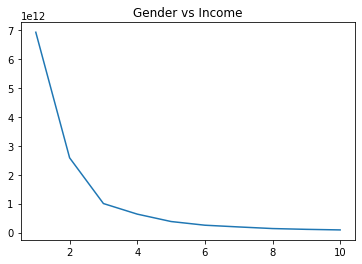

In [96]:
scores = []

for k in range(1,11):
    kmeans = KMeans(k)
    
    model = kmeans.fit(cluster_df_new)
    
    scores.append(abs(model.score(cluster_df_new)))

plt.plot(range(1,11), scores)

plt.title('Gender vs Income')


In [97]:
clust = cluster.AgglomerativeClustering(3, linkage='ward')

optimal_cluster = df_all_customers[['discount_total_offers', 'discount_completion_pct',
       'discount_min_completion_days', 'discount_max_completion_days', 'discount_completed_offers',
       'discount_avg_completion_days', 'discount_avg_net_reward',
       'bogo_total_offers', 'bogo_completion_pct', 'bogo_completed_offers' 'bogo_min_completion_days',
       'bogo_max_completion_days', 'bogo_avg_completion_days',
       'bogo_avg_net_reward', 'informational_promotions', 'age', 'gender',
       'income', 'total_transactions', 'min_transaction_day',
       'max_transaction_day', 'avg_transaction', 'total_transaction_amount',
       'median_days_between_purchases', 'avg_days_between_purchases']].fillna(0)

optimal_cluster_new = pd.get_dummies(data=optimal_cluster, columns=['gender'])

df_all_customers['Clusters'] = clust.fit_predict(optimal_cluster_new)

In [98]:
df_all_customers.head()


,person,discount_total_offers,discount_completion_pct,discount_min_completion_days,discount_max_completion_days,discount_completed_offers,discount_avg_completion_days,discount_avg_net_reward,bogo_total_offers,bogo_completion_pct,...,total_transactions,min_transaction_day,max_transaction_day,avg_transaction,total_transaction_amount,median_days_between_purchases,avg_days_between_purchases,bogo_completed_offers,bogo_min_completion_days,Clusters
0,0009655768c64bdeb2e877511632db8f,1,1,0.0,0.0,1,0.0,-8,1,1,...,8,228,696,15.950000,127.60,27.0,59.25,1.0,6.0,2
0,00116118485d4dfda04fdbaba9a87b5c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,0,...,3,294,474,1.363333,4.09,18.0,62.00,0.0,NaN,2
0,0011e0d4e6b944f998e987f904e8c1e5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5,132,654,15.892000,79.46,66.0,105.60,NaN,NaN,0
0,0020c2b971eb4e9188eac86d93036a77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,...,8,54,708,24.607500,196.86,21.0,82.50,0.0,NaN,1
0,0020ccbbb6d84e358d3414a3ff76cffd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12,42,672,12.837500,154.05,30.0,53.00,NaN,NaN,0


In [99]:
df_all_customers.Clusters.value_counts(normalize = True)


0    0.408882
2    0.334941
1    0.256176
Name: Clusters, dtype: float64

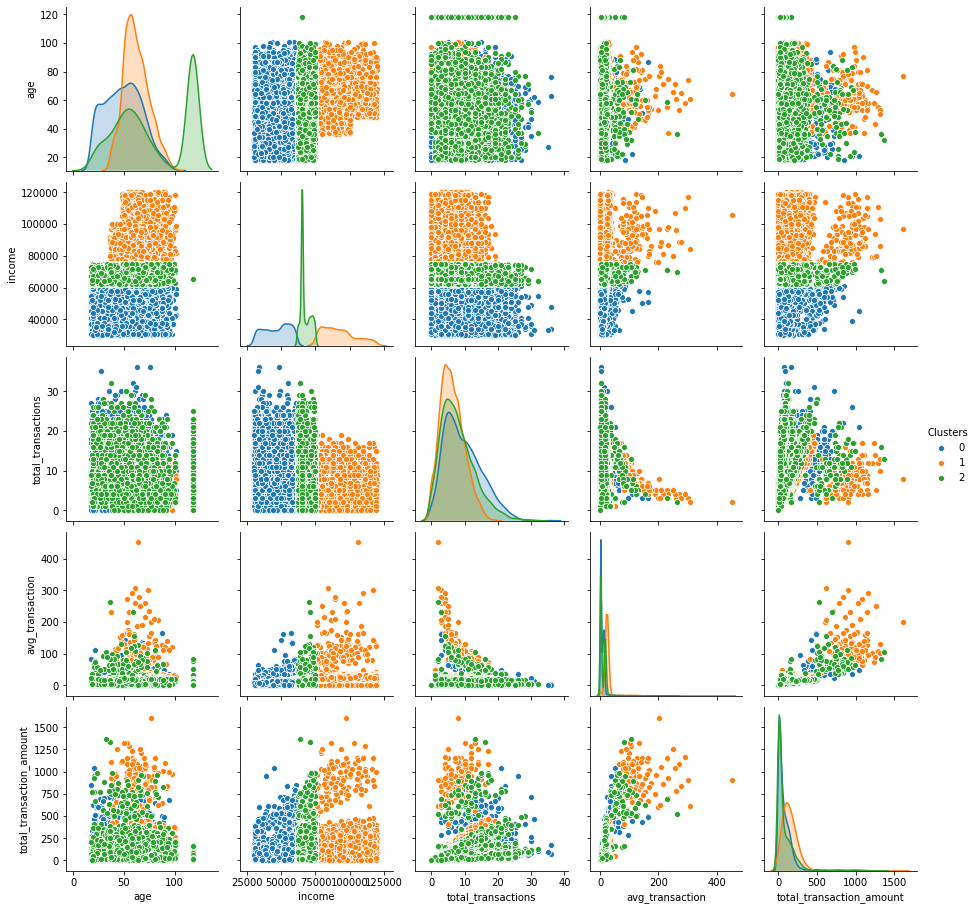

In [100]:
visual_columns = ['age'
                  , 'gender'
                  ,'income'
                  , 'total_transactions'
                  , 'avg_transaction'
                  , 'total_transaction_amount'
                  ,'Clusters']

sns_personal_attributes = sns.pairplot(df_all_customers[visual_columns].fillna(0), hue='Clusters');
sns_personal_attributes.savefig("personal_attributes_clusters.png")

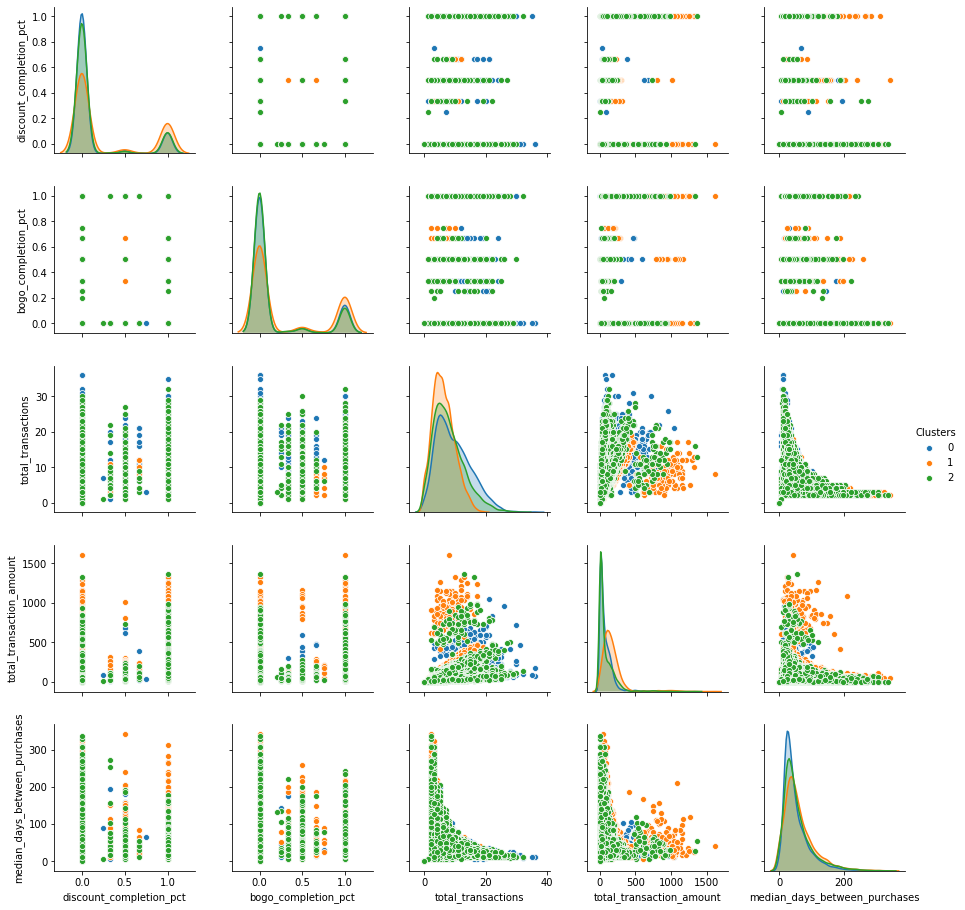

In [101]:
visual_columns = ['discount_completion_pct','bogo_completion_pct',
        'total_transactions', 'total_transaction_amount',
       'median_days_between_purchases','Clusters']

seaborn_trans_info = sns.pairplot(df_all_customers[visual_columns].fillna(0), hue='Clusters')
seaborn_trans_info.savefig("personal_transactions_clusters.png")

<Figure size 720x576 with 0 Axes>

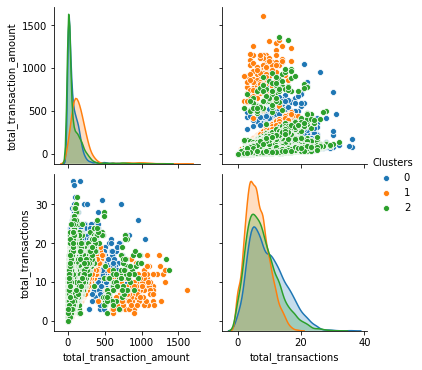

In [102]:
plt.figure(figsize= (10,8))
sns.pairplot(df_all_customers[['total_transaction_amount','total_transactions','Clusters']].fillna(0), hue='Clusters');

<Figure size 1440x720 with 0 Axes>

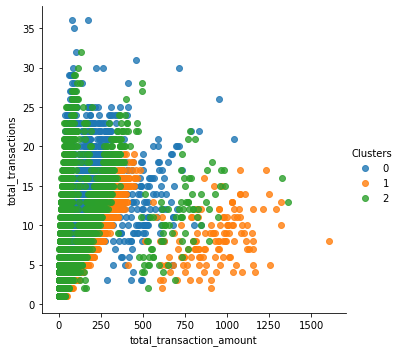

In [103]:

plt.figure(figsize = (20,10))
sns.lmplot(x='total_transaction_amount', y='total_transactions', hue='Clusters'
           , data=df_all_customers, fit_reg=False);

<Figure size 1440x1440 with 0 Axes>

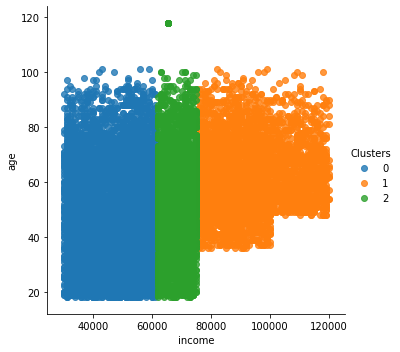

In [104]:
plt.figure(figsize = (20,20));
sns.lmplot(x='income', y='age', hue='Clusters'
           , data=df_all_customers, fit_reg=False);

In [105]:
clust_offer = pd.merge(offers_df, df_all_customers[['person','Clusters']]).groupby(
                            ['Clusters','offer_type','difficulty','reward']
                            , as_index = False ).agg({

     'CompletedOffer':['mean', 'sum'] 
    , 'DaysToCompleteOffer':'mean' 
    , 'NetReward': 'max' 
})

clust_offer = clust_offer[clust_offer['offer_type'] != 'informational']
clust_offer.columns.droplevel(1)
clust_offer.columns = ['Clusters','offer_type','difficulty','reward' , 'CompletedOffers','TotalCompletions','AvgDaysToCompleteOffer','NetReward']

In [106]:
clust_offer

,Clusters,offer_type,difficulty,reward,CompletedOffers,TotalCompletions,AvgDaysToCompleteOffer,NetReward
0,0,bogo,5,5,0.287234,1026,8.801170,0
1,0,bogo,10,10,0.156899,688,9.034884,0
2,0,discount,7,3,0.367496,502,8.677291,-4
3,0,discount,10,2,0.215789,656,8.917683,-8
4,0,discount,20,5,0.037056,73,12.246575,-15
6,1,bogo,5,5,0.511532,865,8.608092,0
7,1,bogo,10,10,0.526596,891,9.077441,0
8,1,discount,7,3,0.602015,478,8.924686,-4
9,1,discount,10,2,0.561009,823,8.712029,-8
10,1,discount,20,5,0.340974,238,8.394958,-15


In [107]:
def bogo_or_discount(row):
    offer_type = row['offer_type']
    cluster_val = row['ClusterCompletedOffers']
    avg_val = row['AvgCompletedOffers']
    
    if cluster_val > avg_val:
        return 'discount'
    else:
        return 'bogo'

In [108]:
rewards_comparisons = pd.merge(clust_offer
         , final_overall_offers_df[['offer_type','difficulty','reward', 'CompletedOffers']]
         , how = 'inner'
         , on = ['offer_type','difficulty','reward']
        ).sort_values(['Clusters','offer_type','difficulty','reward'])
rewards_comparisons.columns = ['Clusters', 'offer_type', 'difficulty', 'reward', 'ClusterCompletedOffers',
       'TotalCompletions', 'AvgDaysToCompleteOffer', 'NetReward',
       'AvgCompletedOffers']

rewards_comparisons['BOGO_or_Discount'] = rewards_comparisons.apply(bogo_or_discount, axis = 1)
rewards_comparisons[['Clusters', 'offer_type', 'difficulty', 'reward'
                  , 'ClusterCompletedOffers','AvgCompletedOffers','BOGO_or_Discount']
                 ].set_index(['Clusters','offer_type'
                            ,'difficulty', 'reward'])

ClusterCompletedOffers  \
Clusters offer_type difficulty reward                           
0        bogo       5          5                     0.287234   
                    10         10                    0.156899   
         discount   7          3                     0.367496   
                    10         2                     0.215789   
                    20         5                     0.037056   
1        bogo       5          5                     0.511532   
                    10         10                    0.526596   
         discount   7          3                     0.602015   
                    10         2                     0.561009   
                    20         5                     0.340974   
2        bogo       5          5                     0.224138   
                    10         10                    0.149921   
         discount   7          3                     0.275216   
                    10         2                     0.202934   
                    20         5                     0.048321   

                                       AvgCompletedOffers BOGO_or_Discount  
Clusters offer_type difficulty reward                                       
0        bogo       5          5                 0.308293             bogo  
                    10         10                0.217532             bogo  
         discount   7          3                 0.383878             bogo  
                    10         2                 0.279512             bogo  
                    20         5                 0.090034             bogo  
1        bogo       5          5                 0.308293         discount  
                    10         10                0.217532         discount  
         discount   7          3                 0.383878         discount  
                    10         2                 0.279512         discount  
                    20         5                 0.090034         discount  
2        bogo       5          5                 0.308293             bogo  
                    10         10                0.217532             bogo  
         discount   7          3                 0.383878             bogo  
                    10         2                 0.279512             bogo  
                    20         5                 0.090034             bogo

<Figure size 720x720 with 0 Axes>

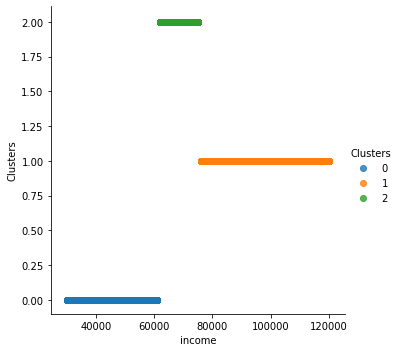

<Figure size 720x720 with 0 Axes>

In [110]:
sns.lmplot(x='income', y='Clusters', hue='Clusters', data=df_all_customers, fit_reg=False)
#plt.xlabel('Income', fontsize = 12)
#plt.ylabel('Cluster', fontsize = 12)
plt.figure(figsize=(10,10))

# Conclusion

Clustering by income works well to differentiate between the app users. From what we can see in the final chart, the higher income indivduals overall respond better with the discount offers, and the lower income individuals respond better to BOGO rewards. However there are some problems with the method, for example many of the users in the dataset did not have an income associated with their account. To combat this I filled the empty values with the mean income, for this experiment that solution works. However if a new user signs up for the app and does not provide any income there would be no way to tell which reward to send them. Instead I believe we could use something like a ranked based recommendation to solve this issue. Send them one of the rewards that are more popular among all of the clusters, then as the user complete more offers we can begin to group them into a certain cluster.